# Source code

## Connecting to Google Drive (DELETE DELETE DELTE!!!)

In [ ]:
# INSTALL NEEDED MODULES:

!pip install emoji optuna

In [ ]:
# CONNECT TO COLAB AND GO TO THE DATA FOLDER IF NEEDED:

from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('./drive/MyDrive/data/tue_lai')

## Data Pipelines

In [5]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold

import string
import emoji
import numpy as np

from typing import *

nltk.download("punkt")
nltk.download('stopwords')

SEED = 42

In [6]:
class StylometryFeatureExtractor(BaseEstimator, TransformerMixin):
    """
    A class to extract style features from the provided data.
    """
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stylometry_features = []
        for text in X:
            # Tokenize sentences and words
            sentences = [word_tokenize(sentence) for sentence in sent_tokenize(text)]
            words = [word for sentence in sentences for word in sentence]

            # Basic stylometry features
            features = {
                'sentence_count': len(sentences),
                'word_count': len(words),
                'avg_sentence_length': len(words) / len(sentences) if len(sentences) > 0 else 0,
                'avg_word_length': sum(len(word) for word in words) / len(words) if len(words) > 0 else 0,
                'num_punctuation': sum(1 for char in text if char in string.punctuation),
                'num_uppercase': sum(1 for char in text if char.isupper()),
                'num_digits': sum(1 for char in text if char.isdigit()),
                'num_emojis': len([char for char in text if char in emoji.EMOJI_DATA])
            }

            stylometry_features.append(features)

        return pd.DataFrame(stylometry_features)

In [7]:
def split_transform(transformer: Functional, 
                    X_train: np.ndarray, y_train: np.ndarray, 
                    X_test: np.ndarray, y_test: np.ndarray) -> Dict:
    """
    Transform the given data with the given transformer and return in dict.
    """
    output = dict()

    output['X_train'] = transformer.fit_transform(X_train)
    output['X_test'] = transformer.transform(X_test)

    output['y_train'] = y_train
    output['y_test'] = y_test

    return output


def get_fold_transformed(X: np.ndarray, y: np.ndarray, transformer: Functional, k: int = 3) -> List:
    """
    Get a list of k folds of the  the given data with the given transformer and return in dict.
    """
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    result = []

    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        result.append(split_transform(transformer,
                                      X_train, y_train,
                                      X_test, y_test))
    return result

def get_pipeline_data(X: np.ndarray, y: np.ndarray) -> Dict[str: List[Dict[]]]:
    """
    Transform the raw data with user posts and target labels with two pre-processing methods:
    1) BoW and 2) BoW + StylometryFeatureExtractor. 
    Each preprocessing is applied over 3 random folds for cross validation. Store the 3 folds in lists.
    """
    result = dict()

    bow_transformer = Pipeline([
    ('bow', CountVectorizer(stop_words='english')),
    ('scaler', StandardScaler(with_mean=False))
    ])
    result['bow'] = get_fold_transformed(X, y, bow_transformer)

    style_bow_transformer = Pipeline([
    ('features', FeatureUnion([
        ('text', CountVectorizer(stop_words='english')),
        ('stylometry', StylometryFeatureExtractor())
    ])),
    ('scaler', StandardScaler(with_mean=False))
    ])
    result['style_bow'] = get_fold_transformed(X, y, style_bow_transformer)

    return result

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.sparse
import numpy as np
import pandas as pd
import os
import pickle


def label_encode(df: pd.DataFrame, col_name: str):
    """
    Label encode the given column of the given dataframe.
    """
    label_encoder = LabelEncoder()
    df[col_name] = label_encoder.fit_transform(df[col_name])
    return df, label_encoder


def save_data(pipelines_data: dict, path: str) -> None:
    """
    Save the data loaded with get_pipeline_data() locally to .np and .npz files.
    """
    if not os.path.exists(path):
        os.mkdir(path)

    for data_type in pipelines_data.keys():
        if not os.path.exists(f'{path}/{data_type}'):
                os.mkdir(f'{path}/{data_type}')

        for i, fold in enumerate(pipelines_data[data_type]):

            if not os.path.exists(f'{path}/{data_type}/{i}'):
                os.mkdir(f'{path}/{data_type}/{i}')

            for split_type in fold.keys():
                file_path = f'{path}/{data_type}/{i}/{split_type}'
                matrix = fold[split_type]

                if isinstance(matrix, np.ndarray):
                    with open(file_path + '.np', 'wb') as f:
                        np.save(f, matrix)
                else:
                    scipy.sparse.save_npz(file_path + '.npz', matrix)

def load_from_saved(path: str) -> Dict:
    """
    Save the pipeline data from local dir of .np and .npz files.
    """
    result = dict()
    for data_type in os.listdir(path):
        result[data_type] = []
        data_type_path = path + '/' + data_type

        for idx in os.listdir(data_type_path):
            result[data_type].append(dict())
            fold_path = data_type_path + '/' + idx

            for split_file in os.listdir(fold_path):
                print(split_file)
                split_type, extension = split_file.split('.')
                split_path = fold_path + '/' + split_file

                if extension == 'np':
                    result[data_type][-1][split_type] = np.load(split_path)
                else:
                    sparse_matrix = scipy.sparse.load_npz(split_path)
                    result[data_type][-1][split_type] = sparse_matrix
    return result


def get_num_classes(path, target_col) -> int:
    data = pd.read_csv(data_path)
    num_classes = len(data[target_col].value_counts())
    return num_classes


def get_min_class_size(path, target_col) -> int:
    data = pd.read_csv(data_path)
    min_class_size = data[target_col].value_counts().min()
    return min_class_size


def get_data(config: dict) -> Dict, List[str]:
    """
    Using a given dataset config, load from saved if it's already calculated. 
    Otherwise, calculate and save locally.
    """
    DATASET_NAME = config['DATASET_NAME']
    DATASET_PATH = config['DATASET_PATH']
    TARGET_COL = config['TARGET_COL']
    INDEPENDENT_COL = config['INDEPENDENT_COL']
    MIN_CLASS_SIZE = get_min_class_size(DATASET_PATH, TARGET_COL)

    if os.path.exists(f'./pipeline_data_{DATASET_NAME}'):
        print('Loading from saved!')
        pipelines_data = load_from_saved(f'./pipeline_data_{DATASET_NAME}')
        target_classes = list(df[TARGET_COL].unique())
    else:
        print('Calculating all again!')
        data = pd.read_csv(DATASET_PATH)

        data_samples = []
        for val in data[TARGET_COL].unique():
            data_samples.append(data[data[TARGET_COL] == val].sample(MIN_CLASS_SIZE))
        data = pd.concat(data_samples)
        
        df, le = label_encode(data, TARGET_COL)
        target_classes = le.classes_
        
        X = df[INDEPENDENT_COL].copy().values
        y = df[TARGET_COL].copy().values
        
        pipelines_data = get_pipeline_data(X, y)
        save_data(pipelines_data, f'./pipeline_data_{DATASET_NAME}')
        print(f'Saved to {f'./pipeline_data_{DATASET_NAME}'} !')
    return pipelines_data, target_classes

## Evaluations

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np


def eval_preds(y_pred, y_true, classes=, normalize=True, cmap=plt.cm.Blues):
    """
    Show the confusion matrix and a classification report of predictions 
    from given true and the predicted value lists.
    """
    
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


def evaluate_clf(clf, X, y_true, classes, normalize=True, cmap=plt.cm.Blues):
    """
    Show the confusion matrix and a classification report of the given classifier 
    from given classifier, true value labels and the corresponding X array.
    """
    y_pred = clf.predict(X)
    eval_preds(y_pred, y_true, classes, normalize, cmap)

# Fine Tuning and Cross Validation

In [12]:
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
import xgboost as xgb
from functools import partial


optuna.logging.set_verbosity(optuna.logging.WARNING)
xgb.set_config(verbosity=1)
SEED = 42

def rf_objective(trial, X, y) -> np.float:
    """
    Objective function of RandomForestClassifier for optuna fine-tuning.
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 25),
        'max_depth': trial.suggest_int('max_depth', 2, 5)
    }

    model = RandomForestClassifier(**params, random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    inner_scores = cross_val_score(model, X=X, y=y, cv=inner_cv, scoring='accuracy')

    return np.mean(inner_scores)

def xgb_objective(trial, X, y, num_class, use_gpu=True) -> np.float:
    """
    Objective function of XGBClassifier for optuna fine-tuning.
    """
    params = {
        'objective': 'multi:softmax',
        'num_class': num_class,
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'n_estimators': trial.suggest_int('n_estimators', 10, 25),
        'n_jobs': -1 if not use_gpu else None,
        'device': "cuda" if use_gpu else None
    }

    model = XGBClassifier(**params, random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    inner_scores = cross_val_score(model, X=X, y=y, cv=inner_cv, scoring='accuracy')

    return np.mean(inner_scores)

In [14]:
def rf_finetuning(X, y):
    """
    Apply hyperparameter fine-tuning of RandomForestClassifier with Optuna.
    """
    partial_objective_rf = partial(rf_objective, X=X, y=y)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_rf, n_trials=100, seed=SEED)

    best_model = RandomForestClassifier(random_state=SEED, **study.best_params)
    return best_model

def xgb_finetuning(X, y, num_class):
    """
    Apply hyperparameter fine-tuning of XGBClassifier with Optuna.
    """

    partial_objective_xgb = partial(xgb_objective, X=X, y=y, num_class=num_class)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_xgb, n_trials=100, seed=SEED)

    best_model = XGBClassifier(random_state=SEED, **study.best_params)
    return best_model

In [15]:
def nested_cv_rf(folds_list: List[Dict]):
    """
    Fine-tune RandomForestClassifier fine-tuning of RandomForestClassifier with Optuna 
    and Nested Cross Validation on the selected folds data. Finally, show evaluations of best found hyperparameters.
    """
    all_preds = []
    all_y_true = []
    for fold in folds_data:
        X_train, y_train = fold['X_train'], fold['y_train']
        X_test, y_test = fold['X_test'], fold['y_test']

        best_model = rf_finetuning(X_train, y_train)
        best_model.fit(X_train, y_train, random_seed=SEED)
        y_pred = best_model.predict(X_test)

        all_preds.extend(y_pred)
        all_y_true.extend(y_test)

    eval_preds(all_preds, all_y_true)

def nested_cv_xgb(folds_list: List[Dict], num_class: int):
    """
    Fine-tune RandomForestClassifier fine-tuning of XGBClassifier with Optuna 
    and Nested Cross Validation on the given folds data. Finally, show evaluations of best found hyperparameters.
    """
    all_preds = []
    all_y_true = []
    for fold in pipelines_data[data_type]:
        X_train, y_train = fold['X_train'], fold['y_train']
        X_test, y_test = fold['X_test'], fold['y_test']

        best_model = xgb_finetuning(X_train, y_train, num_class)
        best_model.fit(X_train, y_train, random_seed=SEED)
        y_pred = best_model.predict(X_test)

        all_preds.extend(y_pred)
        all_y_true.extend(y_test)

    eval_preds(all_preds, all_y_true)

# Political Leaning Dataset

In [ ]:
config_political = {
    "DATASET_NAME": "political_leaning",
    "DATASET_PATH": "./political_leaning.csv",
    "TARGET_COL": "political_leaning",
    "INDEPENDENT_COL": "post",
    "NUM_CLASSES": get_num_classes(path="./political_leaning.csv", target_col='political_leaning')
}
pipeline_data, target_classes = get_data(config_political)

### No Style SVM

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.68      0.70      4859
           1       0.75      0.74      0.75      4858
           2       0.74      0.77      0.75      4859

    accuracy                           0.73     14576
   macro avg       0.73      0.73      0.73     14576
weighted avg       0.73      0.73      0.73     14576



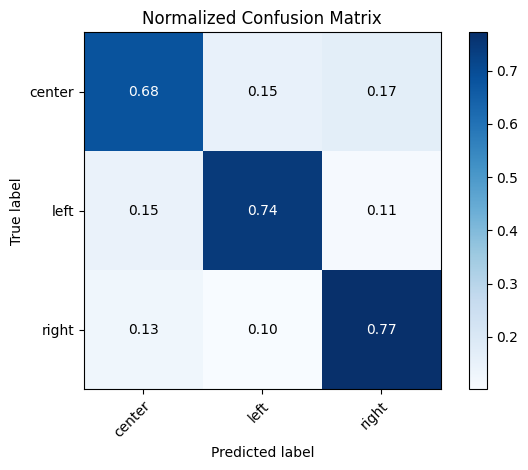

In [ ]:
data_type = 'bow'

clf = LinearSVC(max_iter = 10)
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)

evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### No Style RF/XGB

              precision    recall  f1-score   support

           0       0.74      0.13      0.22     14576
           1       0.52      0.45      0.48     14576
           2       0.41      0.81      0.54     14576

    accuracy                           0.46     43728
   macro avg       0.56      0.46      0.41     43728
weighted avg       0.56      0.46      0.41     43728



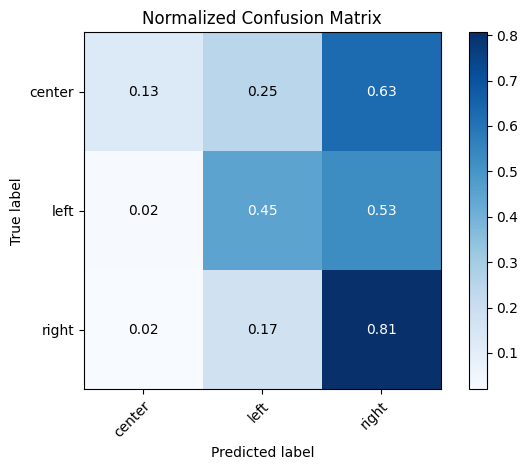

In [ ]:
nested_cv_rf(pipelines_data['bow'])

In [ ]:
nested_cv_xgb(pipelines_data['bow'], num_class=config["NUM_CLASSES"])

### Style SVM

In [ ]:
data_type = 'style_bow'
clf = LinearSVC()
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)
evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### Style RF/XGB

In [ ]:
nested_cv_rf(pipelines_data['style_bow'])

In [ ]:
nested_cv_xgb(pipelines_data['style_bow'], num_class=config["NUM_CLASSES"])

# Feeling/Thinking Dataset

In [17]:
config_feeling = {
    "DATASET_NAME": "feeling_thinking",
    "DATASET_PATH": "./feeling_thinking.csv",
    "TARGET_COL": "feeling",
    "INDEPENDENT_COL": "post",
    "NUM_CLASSES": get_num_classes(path="./feeling_thinking.csv", target_col='feeling')
}
pipeline_data, target_classes = get_data(config_feeling)

### No Style SVM

In [ ]:
data_type = 'bow'

clf = LinearSVC(max_iter = 10)
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)

evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### No Style RF/XGB

In [ ]:
nested_cv_rf(pipelines_data['bow'])

In [ ]:
nested_cv_xgb(pipelines_data['bow'], num_class=config["NUM_CLASSES"])

### Style SVM

In [ ]:
data_type = 'style_bow'

clf = LinearSVC()
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)

evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### Style RF/XGB

In [ ]:
nested_cv_rf(pipelines_data['style_bow'])

In [ ]:
nested_cv_xgb(pipelines_data['style_bow'], num_class=config["NUM_CLASSES"])

# Gender Dataset

In [ ]:
config_gender = {
    "DATASET_NAME": "gender",
    "DATASET_PATH": "./gender.csv",
    "TARGET_COL": "female",
    "INDEPENDENT_COL": "post",
    "NUM_CLASSES": get_num_classes(path="./gender.csv", target_col='female')
}
pipeline_data, target_classes = get_data(config_gender)

### No Style SVM

In [ ]:
data_type = 'bow'

clf = LinearSVC(max_iter = 100)
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)

evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### No Style RF/XGB

In [ ]:
nested_cv_rf(pipelines_data['bow'])

In [ ]:
nested_cv_xgb(pipelines_data['bow'], num_class=config["NUM_CLASSES"])

### Style SVM

In [ ]:
data_type = 'style_bow'

clf = LinearSVC()
clf.fit(pipelines_data[data_type][0]['X_train'], pipelines_data[data_type][0]['y_train'], random_seed=SEED)

evaluate_clf(clf=clf,
             X=pipelines_data[data_type][0]['X_test'],
             y_true=pipelines_data[data_type][0]['y_test'],
             classes=target_classes)

### Style RF/XGB

In [ ]:
nested_cv_rf(pipelines_data['style_bow'])

In [ ]:
nested_cv_xgb(pipelines_data['style_bow'], num_class=config["NUM_CLASSES"])